In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import basic package and Setting basic functions

In [4]:
import numpy as np
from core import stagger_FD_coeff as sfci
from core.utils import cholesky_solver
from neal import SimulatedAnnealingSampler
from dwave.system import DWaveSampler
from core.QUBO_solvers import IterSampleSolver
from collections import ChainMap
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
import time
from functools import wraps
pi = np.pi

In [5]:
def timer_decorator(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.perf_counter()
        result = func(*args, **kwargs)
        end = time.perf_counter()
        print(f"{func.__name__} Time Consuming: {end - start:.6f} s")
        return result

    return wrapper


@timer_decorator
def solve_coeff_Taylor():
    tra_a0_dict = {}
    for M in M_set:
        tra_a0_dict["Tra" + f" M={M}"] = sfci.Taylor_Coef(M)
    return tra_a0_dict


@timer_decorator
def solve_coeff_Wang():
    wang_a0_dict = {}
    for M, freq_max in zip(M_set, freq_max_set):
        linear_sys = sfci.Stagger_FD_coeff_1D(v, h, tao, freq_max, L=20)
        wang_a0_dict["Wang" + f" M={M}"] = linear_sys.solve(
            M=M,
            coeff_vec=sfci.Taylor_Coef(M),  # setting initial FD operator
            alpha=1.0,
            alpha_decay=0.1,
            beta=1.0,
            epsilon=1e-8,
            max_iter_num=max_iter_num,
            mode_of_construct="lstsq",
            solver=cholesky_solver,
            show_process=False,
        )
    return wang_a0_dict, linear_sys


@timer_decorator
def solve_coeff_QA():

    # Using the real Quantum Annealing Hardware Dwave System!
    # You should sign up a count and get your API.
    # sampler = DWaveSampler(
    #     token="YOUR API TOKEN",
    #     solver="Advantage_system6.4",
    #     region="na-west-1",
    # )  #

    # Using your computer to simulate the quantum annealing.
    sampler = SimulatedAnnealingSampler()  # for test

    qa_a0_dict = {}
    for M, freq_max in zip(M_set, freq_max_set):
        linear_sys = sfci.Stagger_FD_coeff_1D(v, h, tao, freq_max, L=20)
        sis = IterSampleSolver(
            sampler=sampler,
            x0=np.ones(M) / 100,  # initial vector of Delta a
            num_sample=100,  # for real hardware device using 2000
            R=10,
            fixed_point=1,
            maxiter=3,  # max iteration in small iteration
            code_method="pn",
            resultMod="lowest_energy",
        )

        qa_a0 = linear_sys.solve(
            M=M,
            coeff_vec=sfci.Taylor_Coef(M),
            alpha=1.0,
            alpha_decay=0.1,
            beta=1.0,
            epsilon=1e-8,
            max_iter_num=max_iter_num,
            mode_of_construct="direct",
            solver=sis.solve,
        )
        qa_a0_dict[f"QA M={M}"] = qa_a0

    return qa_a0_dict

## set plot function

In [6]:
def show_disp_curve(result_dict):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=150)

    lw = 1.1  # linwidth of box
    style_set = ["-", "--", ":"]
    linwith = 1.2
    counter = 0
    for label, coeff in result_dict.items():
        sigma = linear_sys.cal_sigma(
            v * tao / h, np.linspace(pi / 1000, pi, 1000), coeff
        )
        if "Tra" in label:
            ax[0].plot(
                np.linspace(pi / 1000, pi, 1000),
                sigma,
                color="maroon",
                linewidth=linwith,
                ls=style_set[counter],
                label=label,
            )
        elif "QA" in label:
            ax[0].plot(
                np.linspace(pi / 1000, pi, 1000),
                sigma,
                color="midnightblue",
                linewidth=linwith,
                ls=style_set[counter],
                label=label,
            )
        counter = (counter + 1) % 3
        ax[0].set_ylim([0.9, 1.05])
        ax[0].set_xlim([0, 3.142])
        ax[0].set_ylabel(
            "$\delta$", fontfamily="Arial", fontsize=12, math_fontfamily="stix"
        )
        ax[0].set_xlabel(
            "$kh$", fontfamily="Arial", fontsize=12, math_fontfamily="stix"
        )
        ax[0].set_xticks([0, 0.5, 1, 1.5, 2, 2.5, 3])
        ax[0].set_yticks([0.9, 0.95, 1.0, 1.05])
        ax[0].spines["left"].set_linewidth(lw)
        ax[0].spines["top"].set_linewidth(lw)
        ax[0].spines["right"].set_linewidth(lw)
        ax[0].spines["bottom"].set_linewidth(lw)

        ax[0].tick_params(
            top=True,
            right=True,
            which="major",
            direction="in",
            length=4,
            width=1.0,
            colors="black",
            labelsize=8,
        )
        ax[0].xaxis.set_minor_locator(MultipleLocator(0.1))
        ax[0].yaxis.set_minor_locator(MultipleLocator(0.01))
        # ax.xaxis.set_minor_locator(AutoMinorLocator()) #  MultipleLocator(0.2)
        ax[0].tick_params(
            top=True,
            right=True,
            direction="in",
            which="minor",
            length=2,
            width=0.8,
            colors="black",
        )

        # ax[0].text(x=-0.25, y=1.05, s='(a)', fontfamily='serif', fontsize=12)

        ax[0].grid(
            visible=True, axis="both", which="major", linestyle="--", linewidth=0.5
        )
        ax[0].legend(
            title="",
            fontsize="x-small",
            loc="lower left",
            borderpad=1.0,
            borderaxespad=2.0,
            labelspacing=0.5,
            edgecolor="black",
            handlelength=2.0,
        )

    counter = 0
    for label, coeff in result_dict.items():
        sigma = linear_sys.cal_sigma(
            v * tao / h, np.linspace(pi / 1000, pi, 1000), coeff
        )
        if "Wang" in label or "Least" in label:
            ax[1].plot(
                np.linspace(pi / 1000, pi, 1000),
                sigma,
                color="maroon",
                linewidth=linwith,
                ls=style_set[counter],
                label=label,
            )
        elif "QA" in label:
            ax[1].plot(
                np.linspace(pi / 1000, pi, 1000),
                sigma,
                color="midnightblue",
                linewidth=linwith,
                ls=style_set[counter],
                label=label,
            )
        counter = (counter + 1) % 3
        ax[1].set_ylim([0.9, 1.05])
        ax[1].set_xlim([0, 3.142])
        ax[1].set_ylabel(
            "$\delta$",
            fontfamily="Arial",
            fontsize=12,
            math_fontfamily="stix",
        )
        ax[1].set_xlabel(
            "$kh$", fontfamily="Arial", fontsize=12, math_fontfamily="stix"
        )
        ax[1].set_xticks([0, 0.5, 1, 1.5, 2, 2.5, 3])
        ax[1].set_yticks([0.9, 0.95, 1.0, 1.05])
        ax[1].spines["left"].set_linewidth(lw)
        ax[1].spines["top"].set_linewidth(lw)
        ax[1].spines["right"].set_linewidth(lw)
        ax[1].spines["bottom"].set_linewidth(lw)

        ax[1].tick_params(
            top=True,
            right=True,
            which="major",
            direction="in",
            length=4,
            width=1.0,
            colors="black",
            labelsize=8,
        )
        ax[1].xaxis.set_minor_locator(MultipleLocator(0.1))
        ax[1].yaxis.set_minor_locator(MultipleLocator(0.01))
        # ax.xaxis.set_minor_locator(AutoMinorLocator()) #  MultipleLocator(0.2)
        ax[1].tick_params(
            top=True,
            right=True,
            direction="in",
            which="minor",
            length=2,
            width=0.8,
            colors="black",
        )

        ax[1].grid(
            visible=True, axis="both", which="major", linestyle="--", linewidth=0.5
        )
        ax[1].legend(
            title="",
            fontsize="x-small",
            loc="lower left",
            borderpad=1.0,
            borderaxespad=2.0,
            labelspacing=0.5,
            edgecolor="black",
            handlelength=2.0,
        )
    return fig, ax

## Low-Speed Medium

In [ ]:
pi = np.pi

v = 1500
h = 10
tao = 0.001
freq_max_set = [39, 51, 57]
M_set = [4, 6, 8]
max_iter_num = 20
tra_a0_dict = solve_coeff_Taylor()
wang_a0_dict, linear_sys = solve_coeff_Wang()
qa_a0_dict = solve_coeff_QA() 
result_dict = dict(ChainMap(qa_a0_dict, wang_a0_dict, tra_a0_dict))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


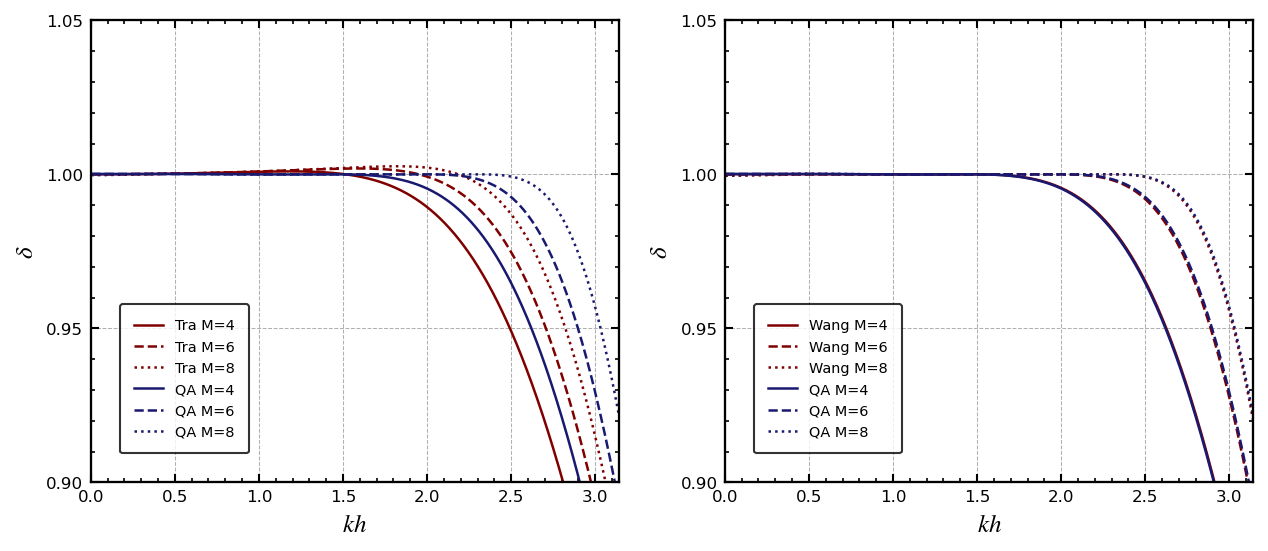

In [8]:
# show results
fig, ax = show_disp_curve(result_dict)
# fig.savefig("1D_low_velocity_reuslt.png", dpi=300)
# fig.savefig("1D_low_velocity_reuslt.pdf", dpi=600, format="pdf")

## High-Speed Medium

In [ ]:
v = 4500
h = 10
tao = 0.001
freq_max_set = [120, 156, 174]
M_set = [4, 6, 8]
max_iter_num = 20
tra_a0_dict = solve_coeff_Taylor()
wang_a0_dict, linear_sys = solve_coeff_Wang()
qa_a0_dict = solve_coeff_QA()
result_dict = dict(ChainMap(qa_a0_dict, wang_a0_dict, tra_a0_dict))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


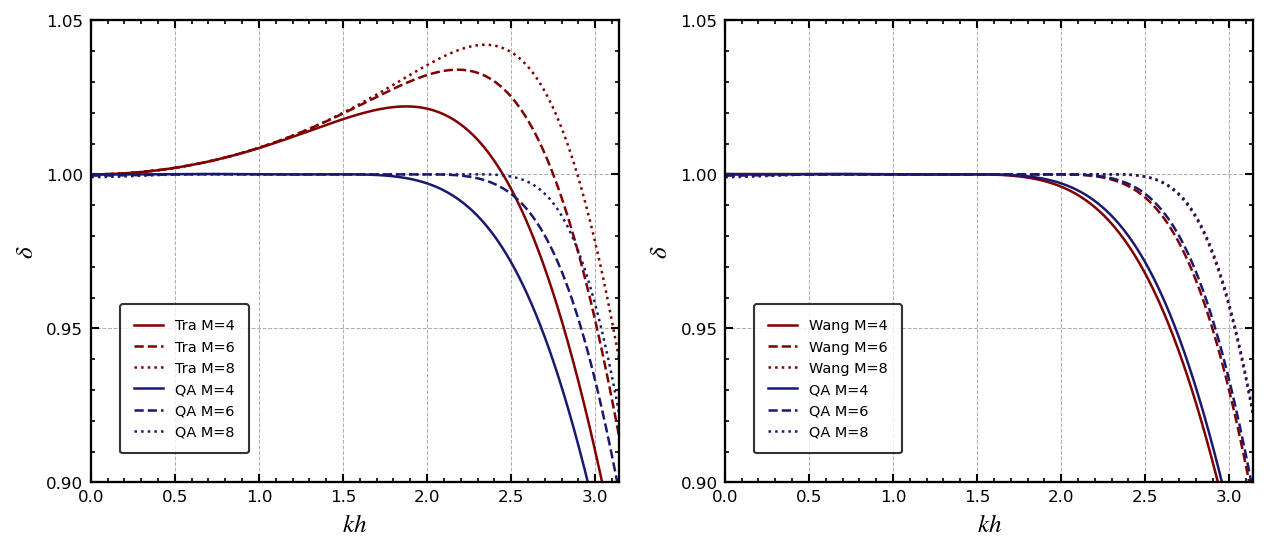

In [26]:
# show results
fig, ax = show_disp_curve(result_dict)
# fig.savefig("1D_high_velocity_reuslt.png", dpi=300)
# fig.savefig("1D_high_velocity_reuslt.pdf", dpi=600, format="pdf")

# Compare with the least square method

In [415]:
def show_disp_curve(result_dict):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150)

    lw = 1.1  # linwidth of box
    style_set = ["-", "--", ":"]
    linwith = 1.2
    counter = 0
    for label, coeff in result_dict.items():
        sigma = linear_sys.cal_sigma(
            v * tao / h, np.linspace(pi / 1000, pi, 1000), coeff
        )
        if "Wang" in label or "Least" in label:
            ax.plot(
                np.linspace(pi / 1000, pi, 1000),
                sigma,
                color="maroon",
                linewidth=linwith,
                ls=style_set[counter],
                label=label,
            )
        elif "QA" in label:
            ax.plot(
                np.linspace(pi / 1000, pi, 1000),
                sigma,
                color="midnightblue",
                linewidth=linwith,
                ls=style_set[counter],
                label=label,
            )
        counter = (counter + 1) % 3
        ax.set_ylim([0.9, 1.05])
        ax.set_xlim([0, 3.142])
        ax.set_ylabel(
            "$\delta$",
            fontfamily="Arial",
            fontsize=15,
            math_fontfamily="stix",
        )
        ax.set_xlabel(
            "$kh$", fontfamily="Arial", fontsize=15, math_fontfamily="stix"
        )
        ax.set_xticks([0, 0.5, 1, 1.5, 2, 2.5, 3])
        ax.set_yticks([0.9, 0.95, 1.0, 1.05])
        ax.spines["left"].set_linewidth(lw)
        ax.spines["top"].set_linewidth(lw)
        ax.spines["right"].set_linewidth(lw)
        ax.spines["bottom"].set_linewidth(lw)

        ax.tick_params(
            top=True,
            right=True,
            which="major",
            direction="in",
            length=4,
            width=1.0,
            colors="black",
            labelsize=10,
        )
        ax.xaxis.set_minor_locator(MultipleLocator(0.1))
        ax.yaxis.set_minor_locator(MultipleLocator(0.01))
        # ax.xaxis.set_minor_locator(AutoMinorLocator()) #  MultipleLocator(0.2)
        ax.tick_params(
            top=True,
            right=True,
            direction="in",
            which="minor",
            length=2,
            width=0.8,
            colors="black",
        )

        ax.grid(
            visible=True, axis="both", which="major", linestyle="--", linewidth=0.5
        )
        ax.legend(
            title="",
            fontsize=10,
            loc="lower left",
            borderpad=1.0,
            borderaxespad=1.0,
            labelspacing=0.5,
            edgecolor="black",
            handlelength=1.0,
        )
    return fig, ax

In [1008]:
def timer_decorator(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.perf_counter()
        result = func(*args, **kwargs)
        end = time.perf_counter()
        print(f"{func.__name__} Time Consuming: {end - start:.6f} s")
        return result

    return wrapper


@timer_decorator
def solve_coeff_Taylor():
    tra_a0_dict = {}
    for M in M_set:
        tra_a0_dict["Tra" + f" M={M}"] = sfci.Taylor_Coef(M)
    return tra_a0_dict


@timer_decorator
def solve_coeff_Wang():
    wang_a0_dict = {}
    for M, freq_max in zip(M_set, freq_max_set):
        linear_sys = sfci.Stagger_FD_coeff_1D(v, h, tao, freq_max, L=25)
        wang_a0_dict["Least Square" + f" M={M}"] = linear_sys.solve(
            M=M,
            coeff_vec=np.ones([M]).reshape(-1, 1),  # setting initial FD operator
            # alpha=1e2,
            # alpha_decay=0.3,
            epsilon=1e-15,
            max_iter_num=max_iter_num,
            mode_of_construct="lstsq",
            show_process=False,
        )
    return wang_a0_dict, linear_sys


@timer_decorator
def solve_coeff_QA():

    # Using the real Quantum Annealing Hardware Dwave System!
    # You should sign up a count and get your API.
    # sampler = DWaveSampler(
    #     token="YOUR API TOKEN",
    #     solver="Advantage_system6.4",
    #     region="na-west-1",
    # )  #

    # Using your computer to simulate the quantum annealing.
    sampler = SimulatedAnnealingSampler()  # for test

    qa_a0_dict = {}
    for M, freq_max in zip(M_set, freq_max_set):
        linear_sys = sfci.Stagger_FD_coeff_1D(v, h, tao, freq_max, L=25)
        sis = IterSampleSolver(
            sampler=sampler,
            x0=np.ones(M),  # initial vector of Delta a
            num_sample=10,  # for real hardware device using 2000
            R=3,
            fixed_point=-1,
            maxiter=10,  # max iteration in small iteration
            code_method="pn",
            resultMod="lowest_energy",
        )

        qa_a0 = linear_sys.solve(
            M=M,
            coeff_vec=np.ones([M]).reshape(-1, 1),
            alpha=1.0e3,
            alpha_decay=0.8,
            beta=1.0,
            epsilon=1e-15,
            max_iter_num=max_iter_num,
            mode_of_construct="direct",
            solver=sis.solve,
        )
        qa_a0_dict[f"QA M={M}"] = qa_a0

    return qa_a0_dict

In [ ]:
v = 4500
h = 10
tao = 0.001

freq_max_set = [180, 205, 210]  # <= v/(2*h)
M_set = [10, 16, 20]

max_iter_num = 150
lstq_a0_dict, linear_sys = solve_coeff_Wang()
qa_a0_dict = solve_coeff_QA()
# result_dict = dict(ChainMap(lstq_a0_dict, tra_a0_dict))

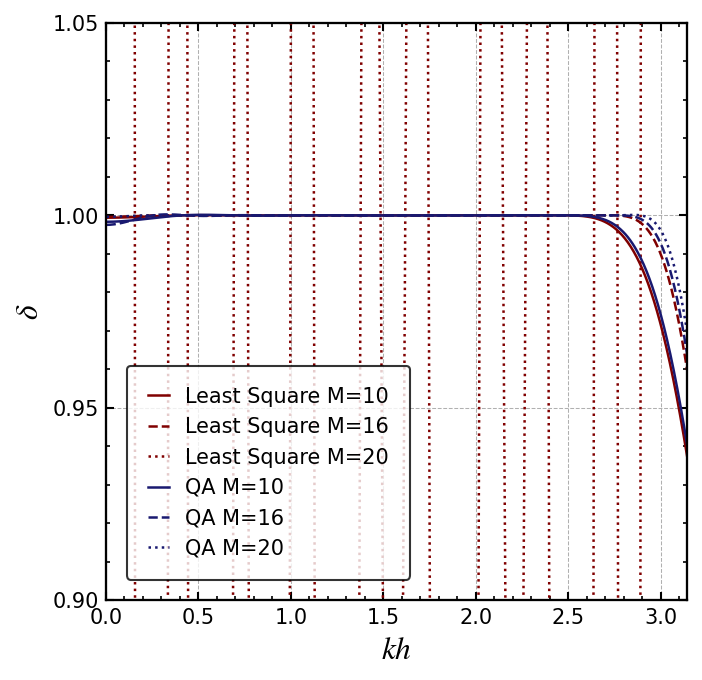

In [ ]:
# show results
result_dict = dict(ChainMap(qa_a0_dict, lstq_a0_dict))
fig, ax = show_disp_curve(result_dict)
# fig.savefig("compare_with_lestsq.png", dpi=600)
# fig.savefig("compare_with_lestsq.pdf", dpi=600, format="pdf")